In [45]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("data0216.txt")

In [47]:
# Streaming models
# Same data and metaheuristics as before, but this time fitting the data in small batches,
# without letting the algorithms have access to all their historical data

from sklearn.linear_model import SGDClassifier
from contextualbandits.online import AdaptiveGreedy
from copy import deepcopy


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True, window_size=50, percentile=90, initial_thr=0.9)

models = [adaptive_greedy_perc]

In [48]:
# These lists will keep track of the rewards obtained by each policy

rewards_agr2 = []

lst_rewards = [rewards_agr2]

# batch size - algorithms will be refit after N rounds
batch_size = 20

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose

lst_a_agr2 = action_chosen.copy()
lst_actions = [lst_a_agr2]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

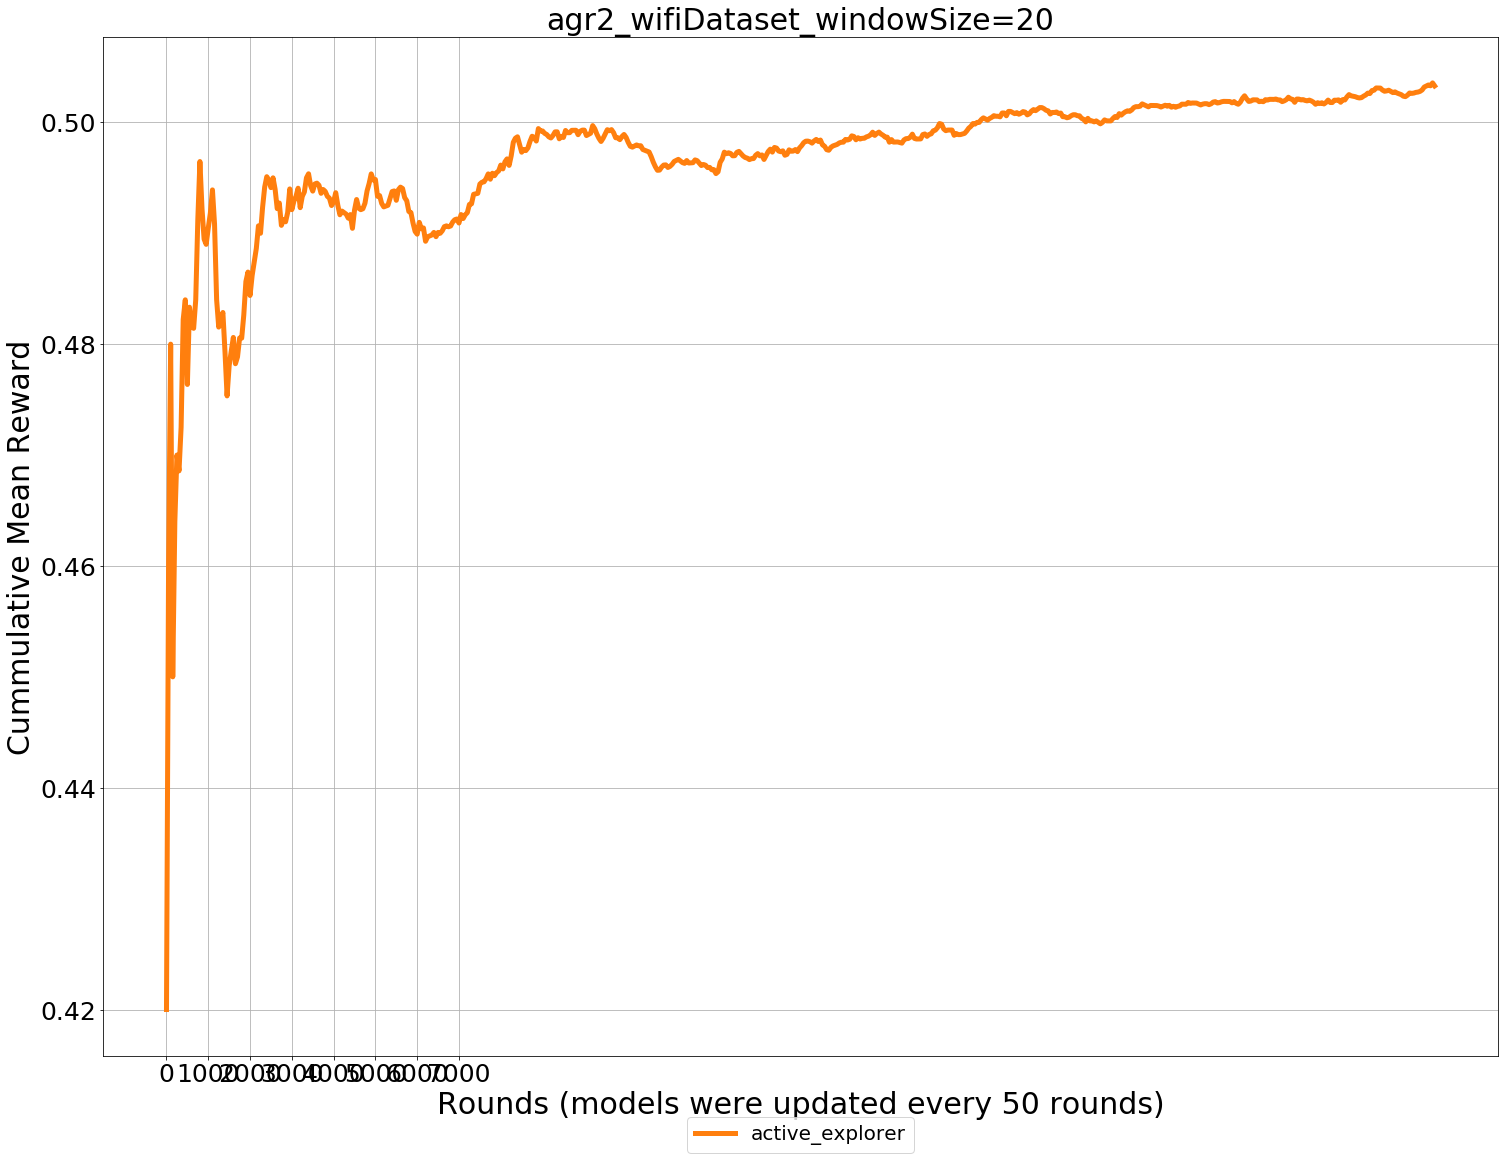

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_wifiDataset_windowSize=20',size=30)
plt.grid()
plt.show()

In [11]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 0 0 1 1 1 1 0 0 1]
[1 0 1 0 1 0 1 1 1 1]
[0 1 0 1 0 1 0 1 1 0]
[1 1 1 1 1 1 0 1 0 1]
[0 0 0 0 0 0 0 0 0 1]
[1 1 0 1 1 1 0 1 0 0]
[0 0 1 0 0 0 0 0 0 1]
[1 0 0 1 1 0 1 1 1 1]
[1 0 1 0 1 1 0 1 1 1]
[0 1 0 0 0 0 1 0 1 1]


In [13]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [14]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 1 0 1 0 1 0 0 1 0]
[1 1 1 1 1 0 1 0 1 1]
[0 1 1 0 0 0 1 0 1 0]
[1 1 0 0 1 1 1 0 1 1]
[0 0 0 1 1 0 0 0 0 1]
[0 0 1 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 1 1 1]
[0 1 1 1 1 0 0 1 0 1]
[1 1 0 1 0 0 1 0 1 1]
[0 1 1 1 0 0 0 1 1 1]


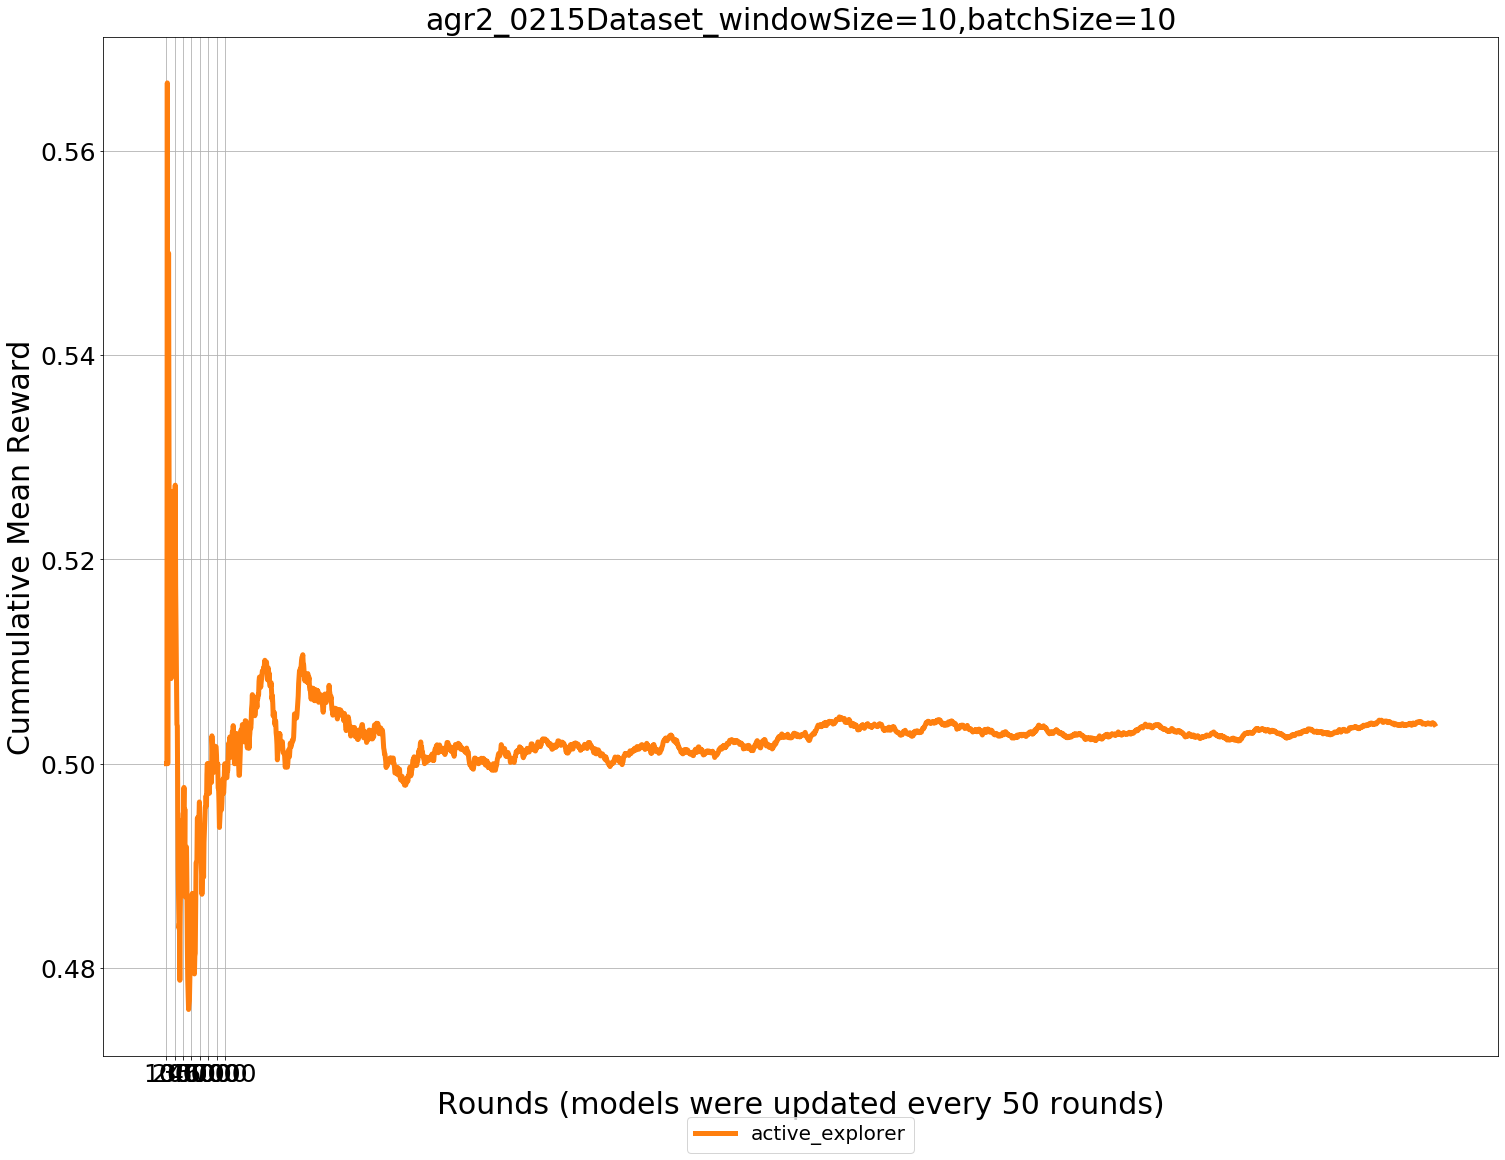

In [18]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_0215Dataset_windowSize=10,batchSize=10',size=30)
plt.grid()
plt.show()

In [1]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)
    

NameError: name 'np' is not defined

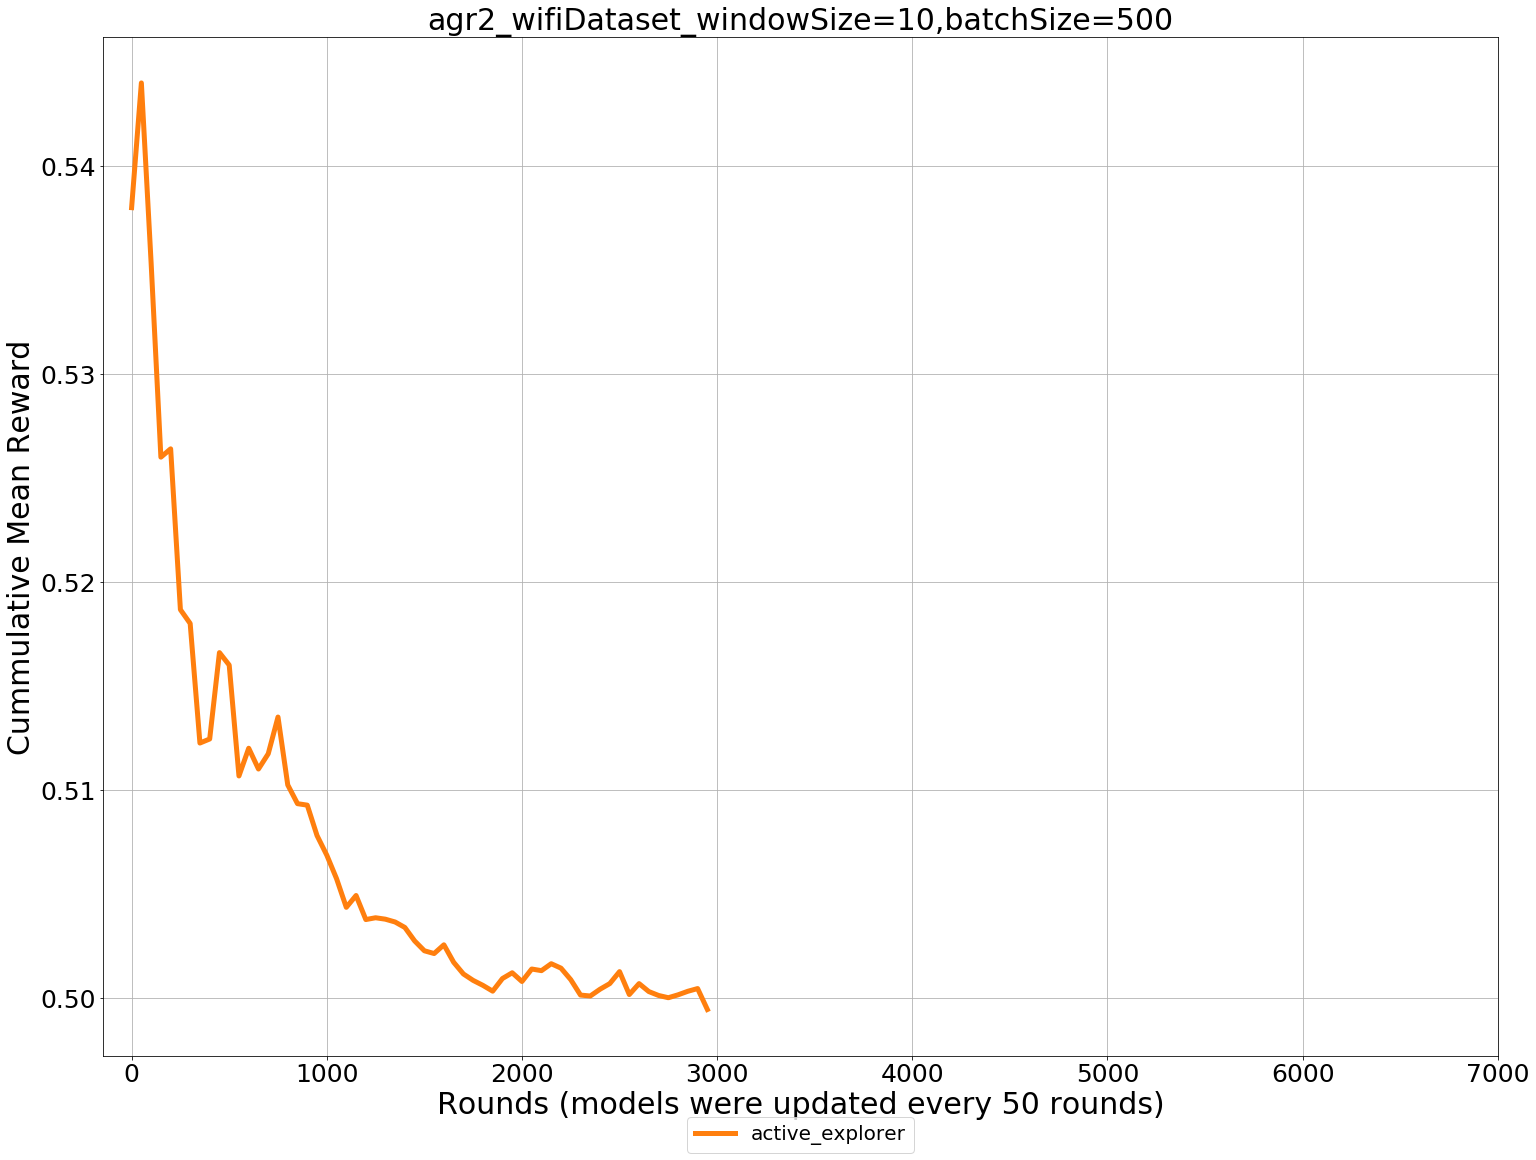

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_wifiDataset_windowSize=10,batchSize=500',size=30)
plt.grid()
plt.show()

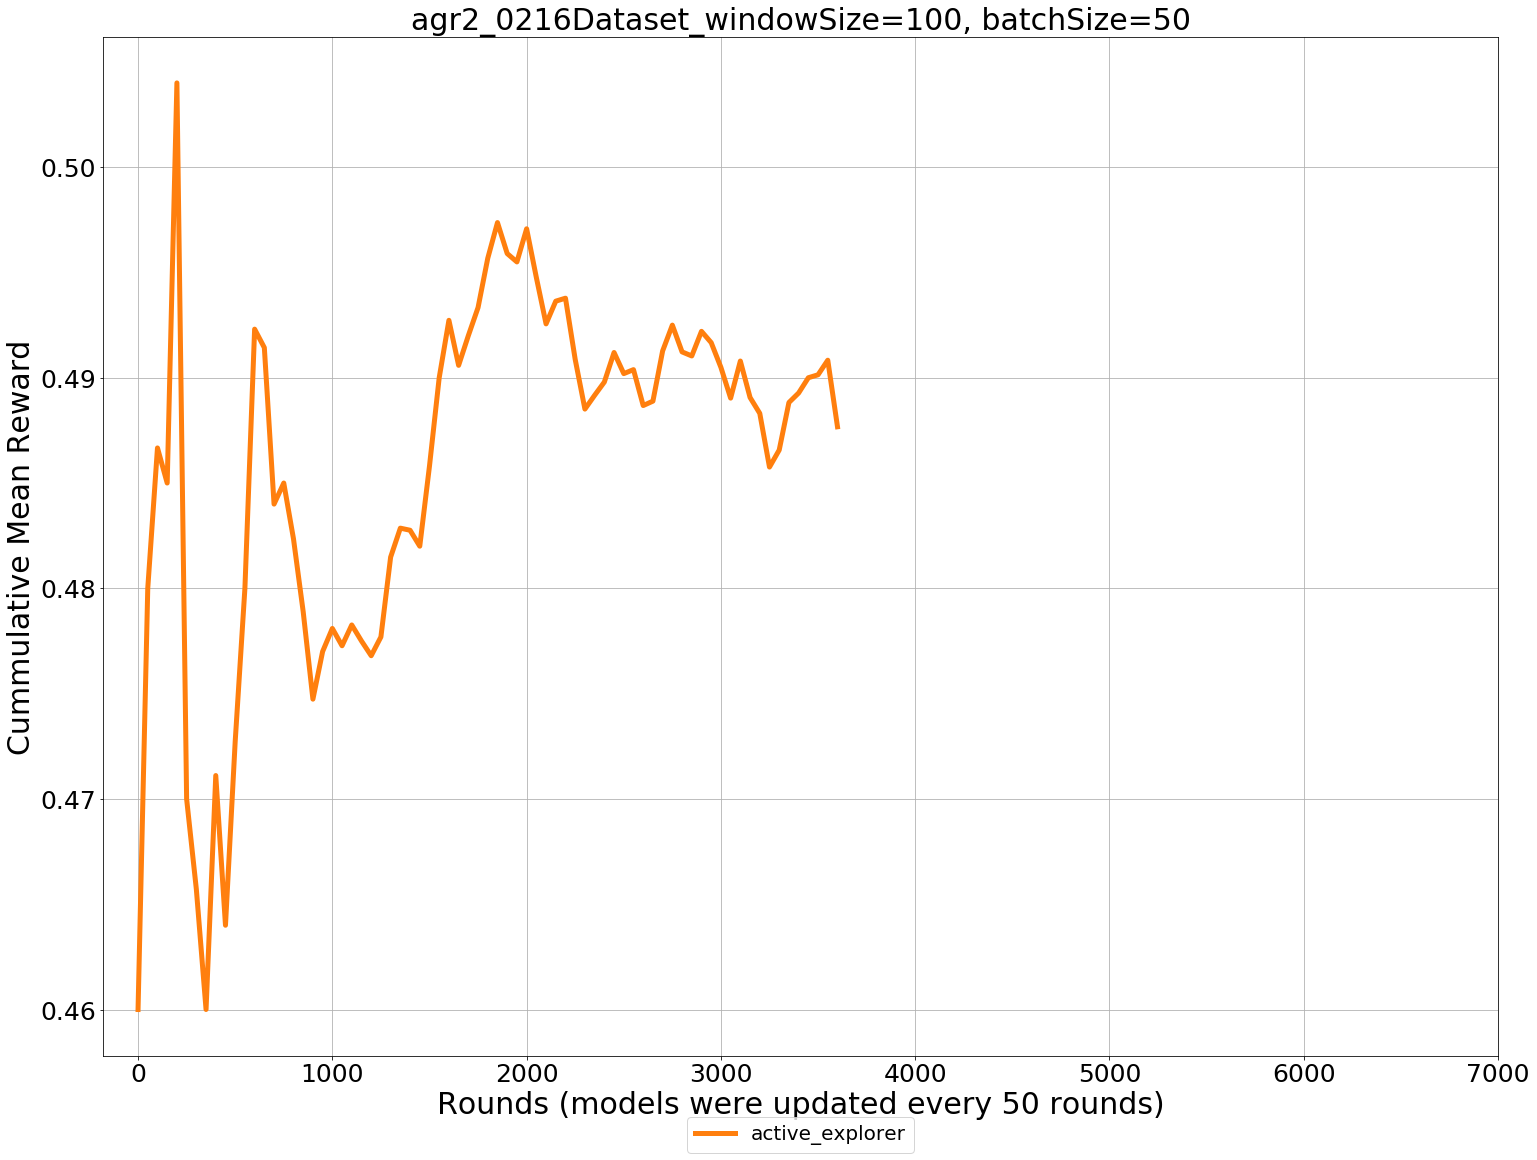

In [12]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_0216Dataset_windowSize=100, batchSize=50',size=30)
plt.grid()
plt.show()

In [13]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[0 0 1 1 0 0 1 1 1 0]
[0 1 0 0 1 0 1 1 1 0]
[0 1 1 0 1 1 1 1 0 1]
[0 0 1 0 0 1 1 0 0 1]
[0 1 0 0 1 0 1 1 1 0]
[1 1 0 1 1 1 1 1 1 0]
[0 0 1 0 0 1 1 0 0 1]
[1 0 0 1 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 1 1]
[0 0 0 1 0 0 0 1 0 0]


In [14]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 0 1 1 1 0 1 1 1 0]
[1 1 0 0 1 1 0 1 1 1]
[0 1 0 1 1 0 1 1 1 1]
[0 0 0 1 0 1 0 1 1 0]
[0 0 1 0 0 0 1 1 0 1]
[1 0 1 0 1 0 1 0 0 0]
[0 1 1 1 1 0 0 1 1 0]
[0 0 1 0 1 0 1 0 0 0]
[0 1 0 1 1 0 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1]


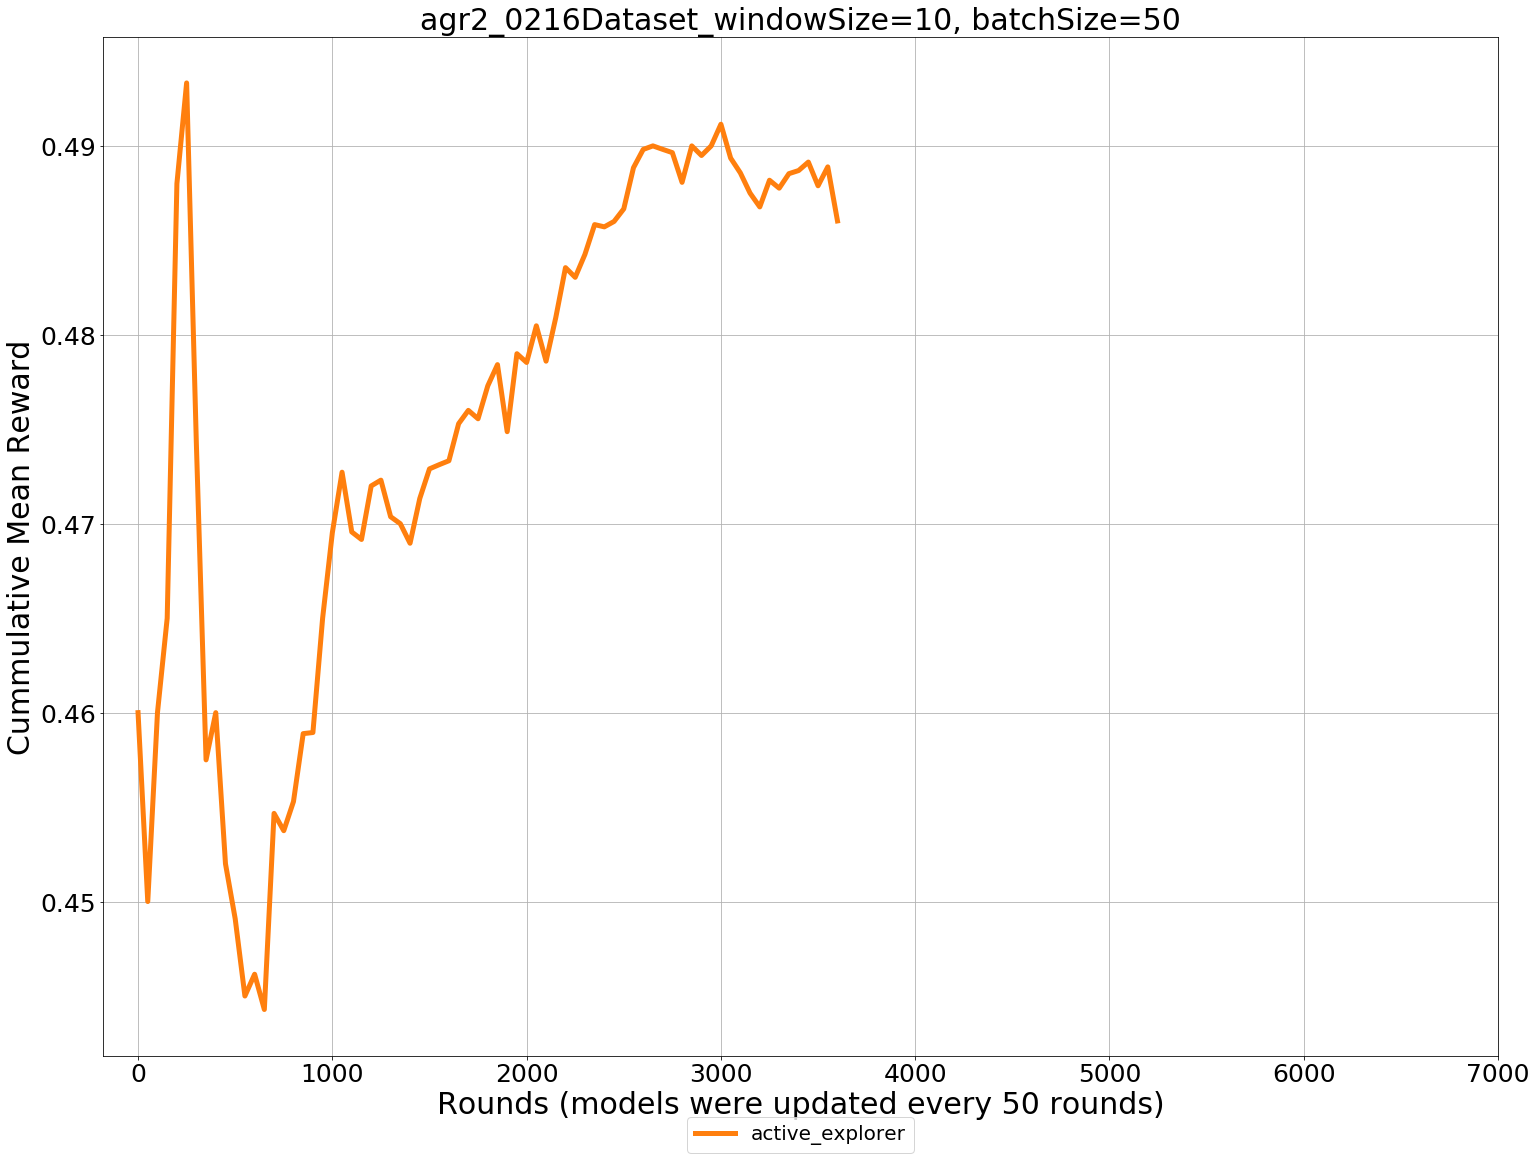

In [17]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_0216Dataset_windowSize=10, batchSize=50',size=30)
plt.grid()
plt.show()

In [18]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 0 1 1 0 1 1 1 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 1 1 0 1 1 0 0]
[0 1 1 0 1 1 1 0 0 0]
[1 0 0 0 1 0 0 1 1 0]
[1 0 1 0 0 0 0 1 0 1]
[0 0 1 0 1 0 0 0 0 0]
[0 0 1 1 1 0 0 1 0 0]
[0 0 1 0 0 1 1 0 0 1]
[0 1 1 0 0 0 0 0 1 0]


In [19]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[0 0 0 1 0 0 0 1 1 1]
[1 1 1 0 0 0 1 0 1 1]
[0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 1 0 1 1 1 1]
[1 0 0 1 1 0 1 0 0 1]
[0 0 0 0 0 1 0 0 1 0]
[0 0 0 1 0 0 1 0 1 1]
[1 0 1 1 0 0 1 1 0 1]
[0 1 0 0 1 1 0 1 1 0]
[0 0 1 0 1 1 0 0 0 1]


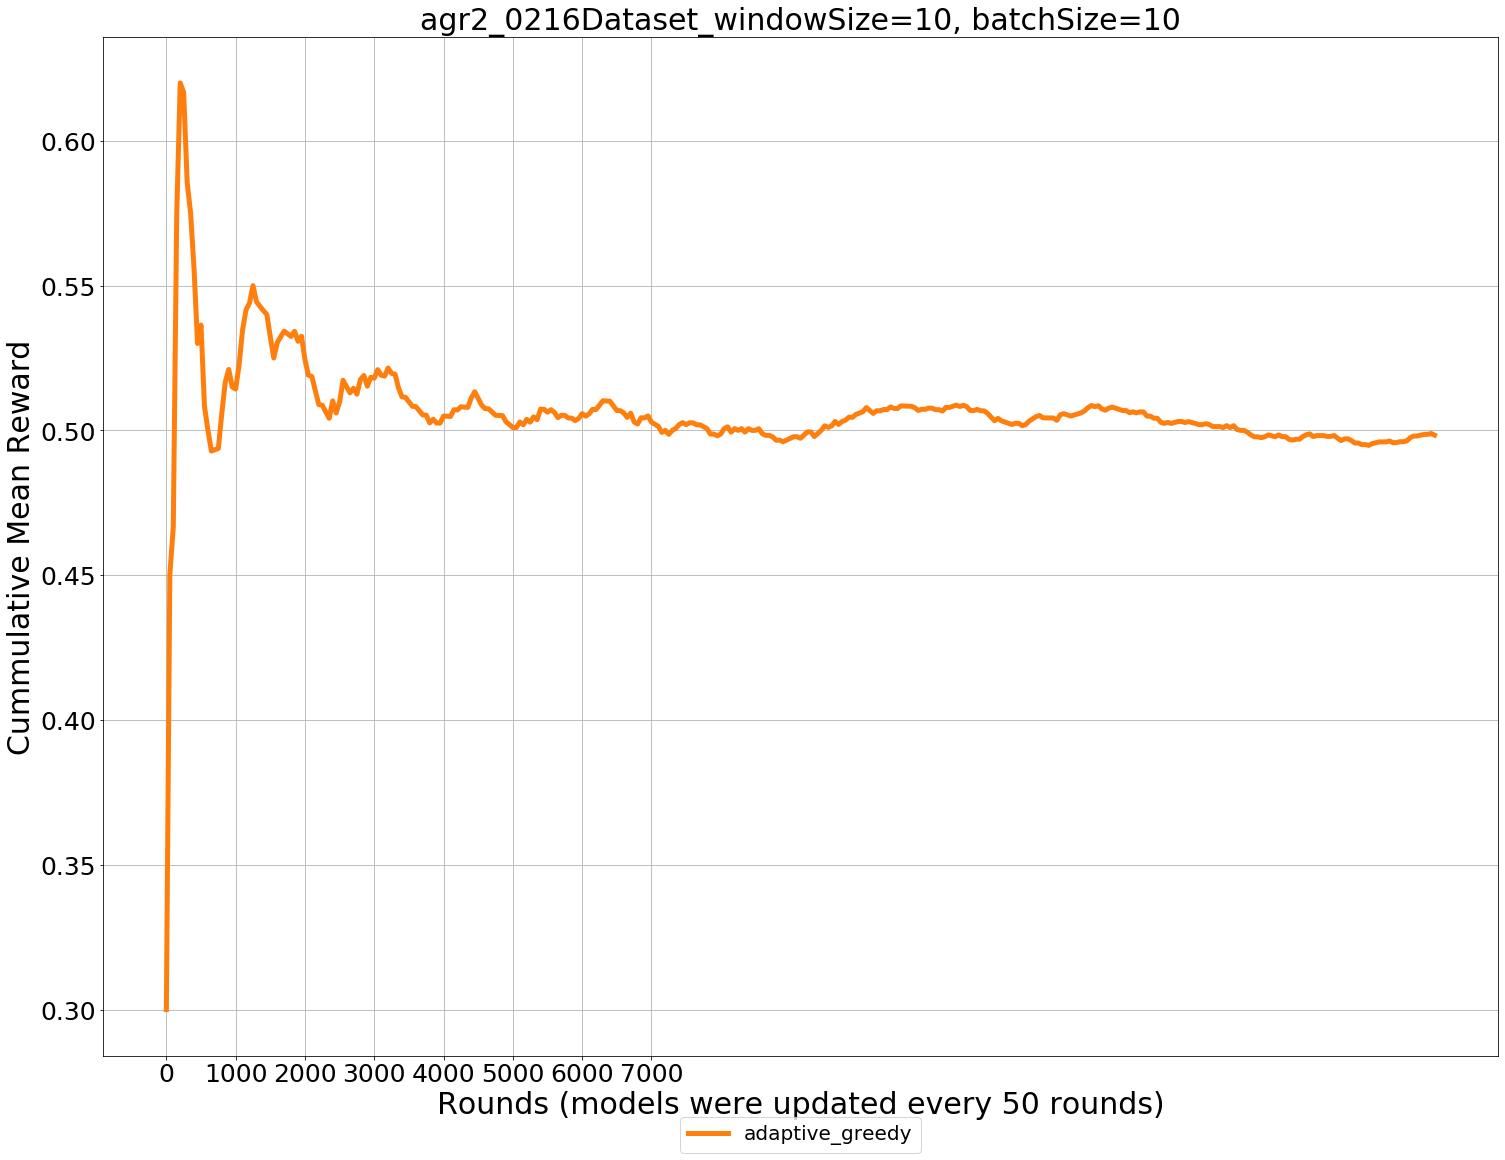

In [21]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_0216Dataset_windowSize=10, batchSize=10',size=30)
plt.grid()
plt.show()

In [22]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 0 1 0 0 0 1 1 0 1]
[1 0 0 1 0 1 0 1 1 1]
[0 1 1 1 0 0 1 1 1 1]
[0 0 1 1 0 1 1 0 1 0]
[0 1 0 1 1 0 1 1 1 1]
[0 1 1 1 1 1 0 0 0 0]
[0 1 0 0 1 0 1 0 0 1]
[0 1 0 0 0 0 1 1 0 1]
[0 0 0 1 1 0 0 1 1 0]
[1 0 1 1 1 1 1 1 0 0]


In [26]:
idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[1 1 1 0 0 1 0 0 1 0]
[1 1 0 0 1 1 0 1 1 0]
[0 1 0 0 1 1 1 1 0 1]
[0 0 1 0 0 1 1 0 0 1]
[0 1 1 1 1 1 1 0 0 1]
[0 1 0 1 0 1 0 0 1 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 1 1]
[0 0 0 1 0 0 0 0 1 1]
[1 0 1 1 0 1 0 1 1 1]


In [27]:
idx

array([1629,  707,  899,  814, 2076, 3569, 1194, 3380, 1641, 1697])

In [25]:
idx

array([ 945, 1084, 1746, 2557,  432, 3376, 2112, 3401,  157, 2869])

In [30]:
#idx = np.random.randint(len(X), size=10)
#idx = list(range(0,5))
idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in idx:
    action = models[0].predict(X[idx,:]).astype("uint8")
    print(action)

[0 1 0 1 0]
[1 0 0 0 0]
[0 1 0 1 0]
[0 0 0 1 0]
[0 1 1 0 1]


In [31]:
idx

range(0, 5)

In [32]:
print(idx)

range(0, 5)


In [36]:
action = models[0].predict(X[0, :]).astype("uint8")
print(action)

[1]


In [43]:
X[0, :]

array([ 1.10000000e+01,  4.61060000e+02,  5.02320000e+01,  2.67161000e+02,
        1.68509000e+02,  2.12200000e+04, -7.30000000e+01,  6.00000000e+00,
        9.20336294e-02,  4.25000000e-01,  4.50243373e-03,  8.70000000e-04,
        2.56300000e-03,  1.30000000e+01,  2.14748365e+09,  2.14748365e+09,
        2.14748365e+09,  2.14748365e+09,  2.14748365e+09,  4.24103000e+02,
        6.10050000e+01,  1.85278000e+02,  8.63680000e+01,  3.59000000e+02,
        1.19927117e-03,  1.68627778e-03,  1.13300000e-03,  2.81000000e-03,
        2.04800000e+03,  5.31920000e+01,  2.33245800e+03,  2.15909000e+02,
        5.37123000e+02,  0.00000000e+00])

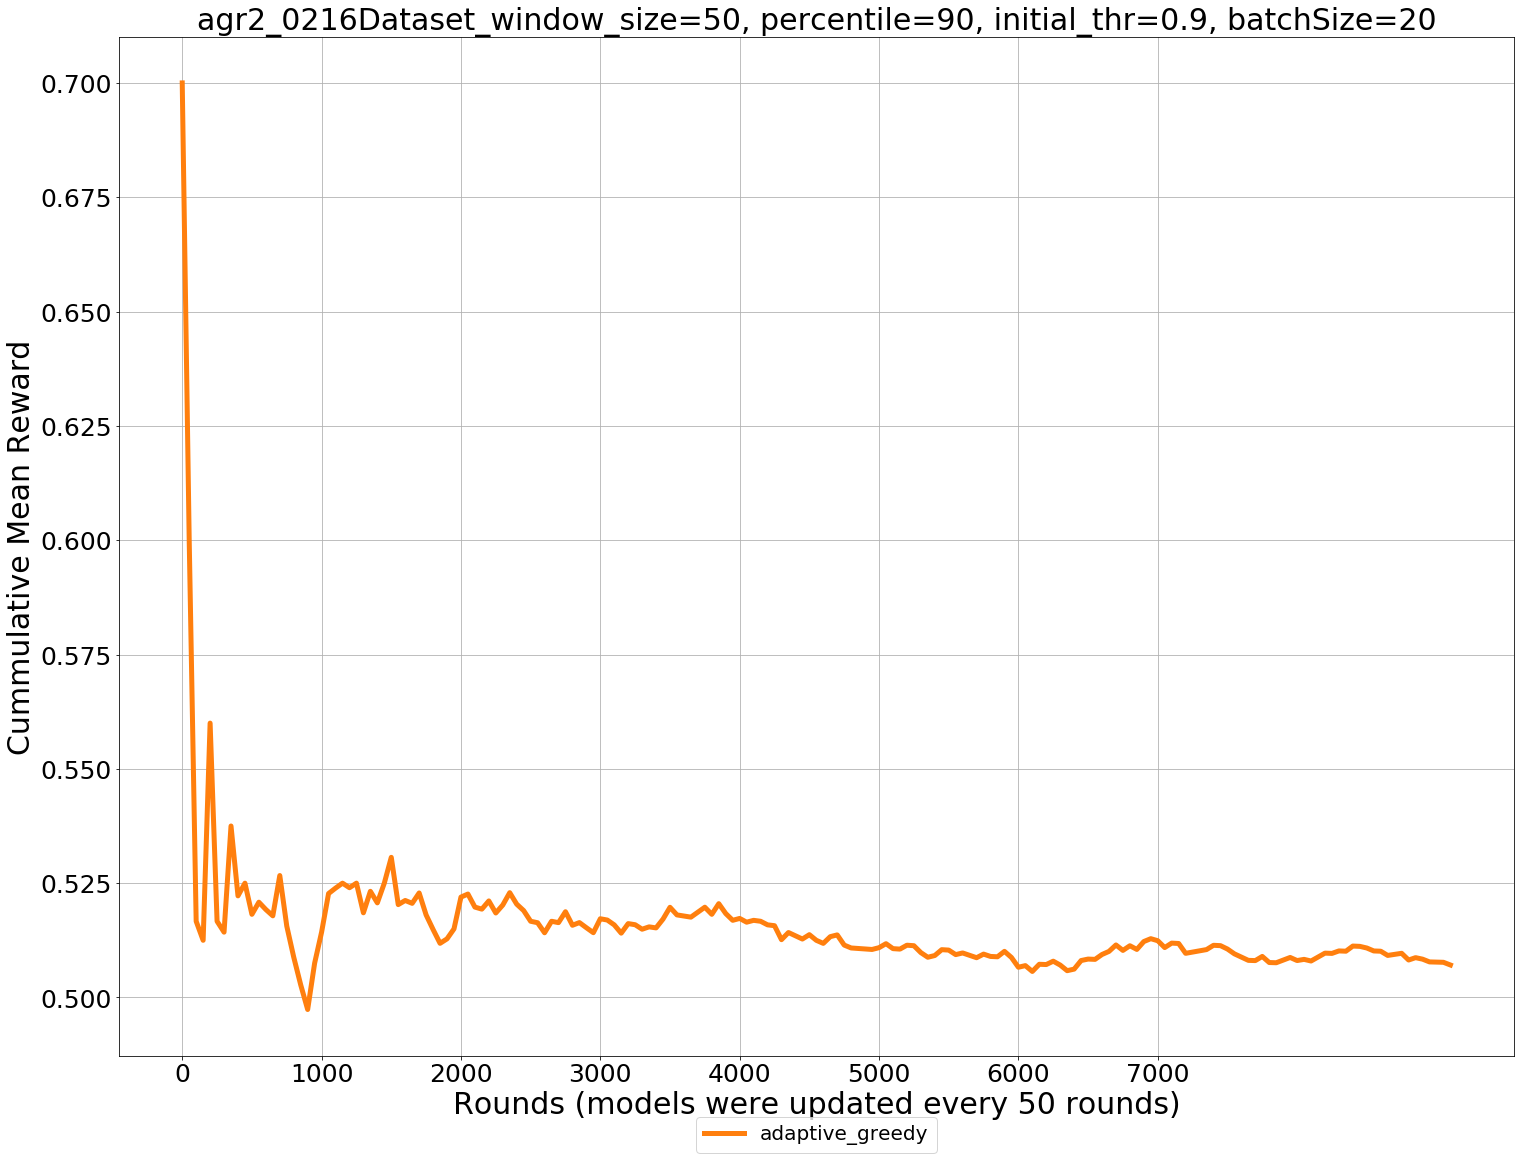

In [49]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('agr2_0216Dataset_window_size=50, percentile=90, initial_thr=0.9, batchSize=20',size=30)
plt.grid()
plt.show()

In [56]:
action = models[0].predict(X[0, :]).astype("uint8")
print(action)

[0]
